In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

use_mps = False

if use_mps and torch.backends.mps.is_available(): # mps turned out to be much slower for some reason
    pt_device = torch.device("mps")
    print("torch using mps")
else:
    pt_device="cpu"
    
torch.set_default_device(pt_device)    

In [2]:
words = open("names.txt").read().splitlines()
print(len(words))
words[:5]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0   
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 8

def build_data(words, block_size):
    X, Y = [], [] 
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random

random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)


X_train, Y_train = build_data(words[:n1], block_size)
X_dev, Y_dev = build_data(words[n1:n2], block_size)
X_test, Y_test = build_data(words[n2:], block_size)

print(X_train.shape, X_dev.shape, X_test.shape)
print(Y_train.shape, Y_dev.shape, Y_test.shape)

for x, y in zip(X_train[:10], Y_train[:10]):
    print(''.join([itos[i.item()] for i in x]), " => ", itos[y.item()])

torch.Size([182567, 8]) torch.Size([22738, 8]) torch.Size([22841, 8])
torch.Size([182567]) torch.Size([22738]) torch.Size([22841])
........  =>  p
.......p  =>  h
......ph  =>  e
.....phe  =>  n
....phen  =>  y
...pheny  =>  x
..phenyx  =>  .
........  =>  t
.......t  =>  z
......tz  =>  v


In [5]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
class Flatten:
    def __call__(self, x):
      self.out = x.view(x.shape[0], -1)
      return self.out
    
    def parameters(self):
      return []

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [6]:
n_embd = 24 
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(2*n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer less confident so it's not wrong at initalization 

parameters = model.parameters()
print(f"number of parameters: {sum(p.numel() for p in parameters)}")
    
for p in parameters:
    p.requires_grad = True

number of parameters: 76579


In [7]:
%%time

max_steps = 200000
batch_size = 32
lossi = []

print(f"expected initial loss {-torch.tensor(1/vocab_size).log()}")

for i in range(max_steps):
    # mini batch, run the whole fordward back ward update in just a small batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    logits = model(X_batch)
    
    loss = F.cross_entropy(logits, Y_batch) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d} loss: {loss.item():.4f}")

    lossi.append(loss.log10().item())

expected initial loss 3.295836925506592
      0/ 200000 loss: 3.3098
  10000/ 200000 loss: 1.9228
  20000/ 200000 loss: 1.8132
  30000/ 200000 loss: 2.3096
  40000/ 200000 loss: 1.9046
  50000/ 200000 loss: 1.7767
  60000/ 200000 loss: 1.8519
  70000/ 200000 loss: 2.1201
  80000/ 200000 loss: 1.8179
  90000/ 200000 loss: 1.7505
 100000/ 200000 loss: 1.8160
 110000/ 200000 loss: 1.9595
 120000/ 200000 loss: 1.8988
 130000/ 200000 loss: 1.4939
 140000/ 200000 loss: 1.7777
 150000/ 200000 loss: 2.3290
 160000/ 200000 loss: 1.5255
 170000/ 200000 loss: 2.0371
 180000/ 200000 loss: 1.7261
 190000/ 200000 loss: 1.7990
CPU times: user 11min 2s, sys: 31min 29s, total: 42min 32s
Wall time: 5min 25s


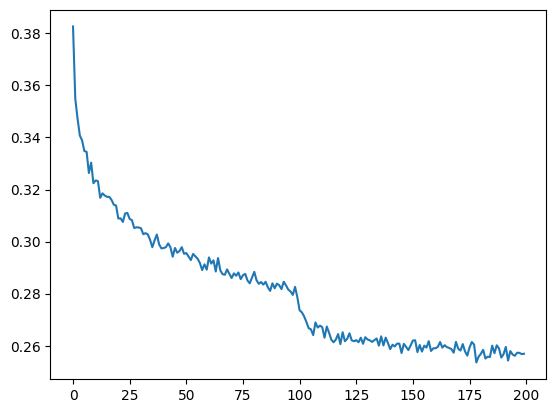

In [8]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [9]:
for layer in model.layers:
    layer.training = False # batch norm should use the whole dataset's mean and variance now

In [10]:
@torch.no_grad()

def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y) 
    print(f"loss for the {split} dataset", loss.item())

split_loss('train')
split_loss('val')

loss for the train dataset 1.7890868186950684
loss for the val dataset 1.9887255430221558


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carman.
amori.
kihlen.
shreyty.
skanden.
jazzus.
favery.
charleigh.
kasiah.
maiir.
kaleigh.
hama.
kindel.
juliani.
marvin.
quinter.
gijaris.
kaileeni.
sabie.
decii.
